In [7]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing as skp
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
import random
from scipy import ndimage
from util import pyvis
from util import extract
from loader import data_loader
from IPython.display import HTML
import util
import warnings

In [8]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [9]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


The Unified Parkinson's Disease Rating Scale (UPDRS) is divided into 4 parts. Part 3, UPDRS-III is motor symptoms and ranges from $[0-132]^1$. From real data, construct a set of simulated data spanning this range. The most correlated radiomic feature will be used to simulate a range of inputs.

In [12]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
#
scaler = skp.StandardScaler() 
X_t,oscaler = util.make_feature_matrix(X_all_c,pre_updrs_off,scaler)
y = per_change



In [13]:
R_all_c.reshape(R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2])[1,1]

'Left red nucleus'

In [14]:
Js = []
for j in np.arange(X_t.shape[1]):
    lr_prepost = linregress(X_t[:,j],per_change)
    
    if lr_prepost.rvalue>0.4:
        Js.append(j)
        print('Feature',str(j),K_all_c.reshape(K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2])[1,j],
              'in ROI',R_all_c.reshape(R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2])[1,j],'has correlation',str(lr_prepost.rvalue))
        # plt.rcParams["figure.figsize"] = (15,5)
        # Cross validation results
        # [fig,ax] = plt.subplots(sharex=True, sharey=True)
        # plt.scatter(X_t[:,j],per_change,)
        # plt.plot(X_t[:,j],X_t[:,j]*lr_prepost.slope+lr_prepost.intercept,'-r')
        # plt.title(['Feature',str(j)])
        # plt.ylabel("DBS improvement")
        # plt.xlabel("Feature")
        # text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
        # plt.text(0.05, 0.95, text,transform=ax.transAxes,
        # fontsize=14, verticalalignment='top')
        # plt.show()

Xc = X_t[:,Js]

Feature 294 lbp-3D-m1_firstorder_90Percentil in ROI Left red nucleus has correlation 0.4003620352537349
Feature 895 wavelet-LLH_gldm_DependenceNonUn in ROI Left red nucleus has correlation 0.4236751348457977
Feature 2852 wavelet-HLH_glcm_JointAverage in ROI Right red nucleus has correlation 0.4447045475922552
Feature 5486 square_glcm_JointEntropy in ROI Right Substantia nigra has correlation 0.4016666039038824
Feature 5495 square_gldm_DependenceVariance in ROI Right Substantia nigra has correlation 0.4135395480282307


In [17]:
Js

[294, 895, 2852, 5486, 5495]

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 47 samples in 0.001s...
[t-SNE] Computed neighbors for 47 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 57.680461
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.048416
[t-SNE] KL divergence after 1000 iterations: 0.795959


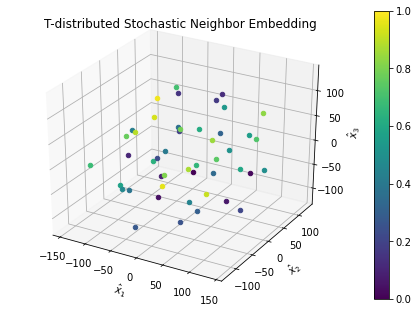

In [15]:
%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)
# Specify 3D embedding
tsne = TSNE(3, verbose=1, perplexity=30, random_state=1, learning_rate='auto', init='random', )
# Fit the high dimensional feature vector
tsne_proj = tsne.fit_transform(X_t)
# Plot f(x,y,z) = DBS outcome
num_categories = len(per_change)
cmap = cm.get_cmap('viridis')
for lab in np.arange(num_categories):
    indices = per_change == lab
    rgba = cmap(lab/num_categories)
    p = ax.scatter(tsne_proj[lab, 0],
               tsne_proj[lab, 1],
               tsne_proj[lab, 2],
               label=per_change[lab],
               alpha=1,color=rgba)
fig.colorbar(p)
ax.set_title('T-distributed Stochastic Neighbor Embedding')
ax.set_xlabel(r'$\hat{x}_1$')
ax.set_ylabel(r'$\hat{x}_2$')
ax.set_zlabel(r'$\hat{x}_3$')
plt.show()

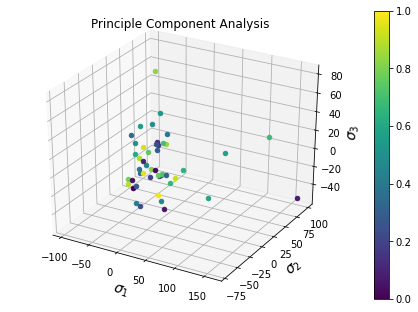

In [16]:
pca = PCA(n_components=3)
pca.fit(X_t) 
X_pca = pca.transform(X_t) 

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio



cdict = {0:'red',1:'green'}
labl = {0:'Malignant',1:'Benign'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure()
ax = Axes3D(fig)
y = per_change
cmap = cm.get_cmap('viridis')
for lab in np.arange(num_categories):
    indices = per_change == lab
    rgba = cmap(lab/num_categories)
    p = ax.scatter(X_pca[lab, 0],
               X_pca[lab, 1],
               X_pca[lab, 2],
               label=per_change[lab],
               alpha=1,color=rgba)

ax.set_xlabel(r'$\sigma_1$', fontsize=14)
ax.set_ylabel(r'$\sigma_2$', fontsize=14)
ax.set_zlabel(r'$\sigma_3$', fontsize=14)
ax.set_title('Principle Component Analysis')
fig.colorbar(p)

plt.show()

[1] R. Balestrino, “Applications of the European Parkinson’s Disease Association sponsored Parkinson’s Disease Composite Scale (PDCS)”, npj Parkinson's Disease, vol. 5, no. 1, 2019, doi: 10.1038/s41531-019-0097-1.